In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when, col

import matplotlib.pyplot as plt

In [2]:
# Build the SparkSession
spark = SparkSession.builder \
   .master("local") \
   .appName("DDAM Project") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()
   
sc = spark.sparkContext

## Import

In [4]:
df_boxscore = spark.read.csv("data/df_boxscore_clean_357.csv", header=True, inferSchema=True)

In [5]:
print(df_boxscore.count())

539171


In [6]:
# Renaming
df_boxscore = df_boxscore.withColumnRenamed("pos_clean", "Position")

In [7]:
df_boxscore.printSchema()

root
 |-- playerName: string (nullable = true)
 |-- FGA: integer (nullable = true)
 |-- 3P: integer (nullable = true)
 |-- 3PA: integer (nullable = true)
 |-- FTA: integer (nullable = true)
 |-- ORB: integer (nullable = true)
 |-- DRB: integer (nullable = true)
 |-- AST: integer (nullable = true)
 |-- STL: integer (nullable = true)
 |-- BLK: integer (nullable = true)
 |-- TOV: integer (nullable = true)
 |-- PF: integer (nullable = true)
 |-- PTS: integer (nullable = true)
 |-- +/-: integer (nullable = true)
 |-- isStarter: integer (nullable = true)
 |-- seasonStartYear: integer (nullable = true)
 |-- isRegular: integer (nullable = true)
 |-- pos7: string (nullable = true)
 |-- Ht: double (nullable = true)
 |-- Wt: double (nullable = true)
 |-- MP_seconds: integer (nullable = true)
 |-- pos3: string (nullable = true)
 |-- pos5: string (nullable = true)
 |-- EFG: double (nullable = true)
 |-- TO_ratio: double (nullable = true)



## Position one-hot-enconding

In [9]:
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="pos5", outputCol="PosNum", handleInvalid="skip")

df_boxscore = indexer.fit(df_boxscore).transform(df_boxscore)

In [22]:
from pyspark.ml.feature import OneHotEncoder
onehotencoder_embarked_vector = OneHotEncoder(inputCol="PosNum", outputCol="PosVec")
df_boxscore = onehotencoder_embarked_vector.fit(df_boxscore).transform(df_boxscore)
df_boxscore.show()

+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------+----------+-------------------+-------------------+------+-------------+
|FGA| 3P|3PA|FTA|ORB|DRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|isRegular|MP_seconds|                EFG|           TO_ratio|PosNum|       PosVec|
+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------+----------+-------------------+-------------------+------+-------------+
| 11|  0|  0|  0|  1|  3|  4|  1|  1|  4|  5| 14| -2|        1|        1|      2240| 0.6363636363636364|0.21052631578947367|   1.0|(4,[1],[1.0])|
|  4|  0|  0|  4|  2|  5|  3|  1|  0|  4|  3|  1|-12|        1|        1|      1894|                0.0|0.31347962382445144|   2.0|(4,[2],[1.0])|
| 13|  1|  2|  2|  0|  2|  5|  1|  1|  2|  2| 17| -7|        1|        1|      1767| 0.5769230769230769|0.09578544061302681|   0.0|(4,[0],[1.0])|
| 11|  0|  0|  2|  1|  5|  0|  0|  2|  1|  2|  8| -7|        1|        1|      1513| 0.2727272727272727|0.07763975155279502|

In [23]:
column2drop = ('playerName', 'game_id', 'teamName', 'seasonStartYear', 'Ht', 'Pos', 'Position', 'Wt', 'feet', 'inches', 'pos3', 'pos7', 'pos5')
df_boxscore = df_boxscore.drop(*column2drop)

In [24]:
# removing correlated features
too_correlated = ('FG', 'FT', 'TRB', 'TSP')
df_boxscore = df_boxscore.drop(*too_correlated)

In [25]:
df_boxscore.printSchema()

root
 |-- FGA: integer (nullable = true)
 |-- 3P: integer (nullable = true)
 |-- 3PA: integer (nullable = true)
 |-- FTA: integer (nullable = true)
 |-- ORB: integer (nullable = true)
 |-- DRB: integer (nullable = true)
 |-- AST: integer (nullable = true)
 |-- STL: integer (nullable = true)
 |-- BLK: integer (nullable = true)
 |-- TOV: integer (nullable = true)
 |-- PF: integer (nullable = true)
 |-- PTS: integer (nullable = true)
 |-- +/-: integer (nullable = true)
 |-- isStarter: integer (nullable = true)
 |-- isRegular: integer (nullable = true)
 |-- MP_seconds: integer (nullable = true)
 |-- EFG: double (nullable = true)
 |-- TO_ratio: double (nullable = true)
 |-- PosNum: double (nullable = false)
 |-- PosVec: vector (nullable = true)



## Data understanding

In [26]:
# Are data balanced?
categorical_columns = ['PosNum']

for column in categorical_columns:
    distinct_values = df_boxscore.groupBy(column).count().collect()
    print(f"Distinct values and frequencies in {column}:")
    for row in distinct_values:
        value = row[column]
        frequency = row["count"]
        print(f"{value}: {frequency}")
    print()

Distinct values and frequencies in PosNum:
0.0: 186058
1.0: 149152
4.0: 59119
3.0: 70249
2.0: 74593



## Data preparation

In [27]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

In [28]:
num_col = [item[0] for item in df_boxscore.dtypes if not item[1].startswith('string')]
num_col.remove("PosNum")
num_col.remove("PosVec")
print(num_col)

['FGA', '3P', '3PA', 'FTA', 'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', '+/-', 'isStarter', 'isRegular', 'MP_seconds', 'EFG', 'TO_ratio']


In [29]:
from pyspark.ml.feature import VectorAssembler, MinMaxScaler

# Selezionare tutte le colonne
selected_columns = num_col

# Creare un VectorAssembler
assembler = VectorAssembler(inputCols=selected_columns, outputCol="features")

# Applicare l'assemblatore
output_dataset = assembler.transform(df_boxscore)

# Creare uno scaler per normalizzare le features
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")

# Applicare lo scaler
output_dataset = scaler.fit(output_dataset).transform(output_dataset)
output_dataset.show(5)

+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------+----------+-------------------+-------------------+------+-------------+--------------------+--------------------+
|FGA| 3P|3PA|FTA|ORB|DRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|isRegular|MP_seconds|                EFG|           TO_ratio|PosNum|       PosVec|            features|     features_scaled|
+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------+----------+-------------------+-------------------+------+-------------+--------------------+--------------------+
| 11|  0|  0|  0|  1|  3|  4|  1|  1|  4|  5| 14| -2|        1|        1|      2240| 0.6363636363636364|0.21052631578947367|   1.0|(4,[1],[1.0])|[11.0,0.0,0.0,0.0...|[0.25,0.0,0.0,0.0...|
|  4|  0|  0|  4|  2|  5|  3|  1|  0|  4|  3|  1|-12|        1|        1|      1894|                0.0|0.31347962382445144|   2.0|(4,[2],[1.0])|[4.0,0.0,0.0,4.0,...|[0.09090909090909...|
| 13|  1|  2|  2|  0|  2|  5|  1|  1|  2|  2| 17| -7|       

In [30]:
classificationData = output_dataset.select("features_scaled", "PosNum")

classificationData.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|features_scaled                                                                                                                                                                                                                                                                          |PosNum|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|[0.25,0.0,0.0,0.0,0.05555555555555555,0.13043478260869565,0.16,0.1,0.07692307692307693,0.3333333333333333,0.7142857142857142,0

In [31]:
(trainingData, testData) = classificationData.randomSplit([0.7, 0.3],seed=1)

In [32]:
# Validation split
(trainingData, valData) = trainingData.randomSplit([0.8, 0.2],seed=1)

In [33]:
trainingData.show(100, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|features_scaled                                                                                                                                                                                                                          |PosNum|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|(18,[0,1,2,3,4,5,11,12,15,16],[0.06818181818181818,0.07142857142857142,0.041666666666666664,0.05128205128205128,0.05555555555555555,0.043478260869565216,0.09999999999999999,0.5614035087719298,0.02539763981528989,0.7777777777777778]) |0.0   |
|(18,[0,1,2,3,4,5,11,12,15,1

## Decision Tree

In [34]:
def plot_importance(importance):
    keys = importance.keys()
    values = importance.values()

    # Plot the dictionary
    plt.figure(figsize=(17,5))
    plt.bar(keys, values)
    plt.xlabel("Keys")
    plt.ylabel("Values")
    plt.title("Feature importance")
    plt.show()

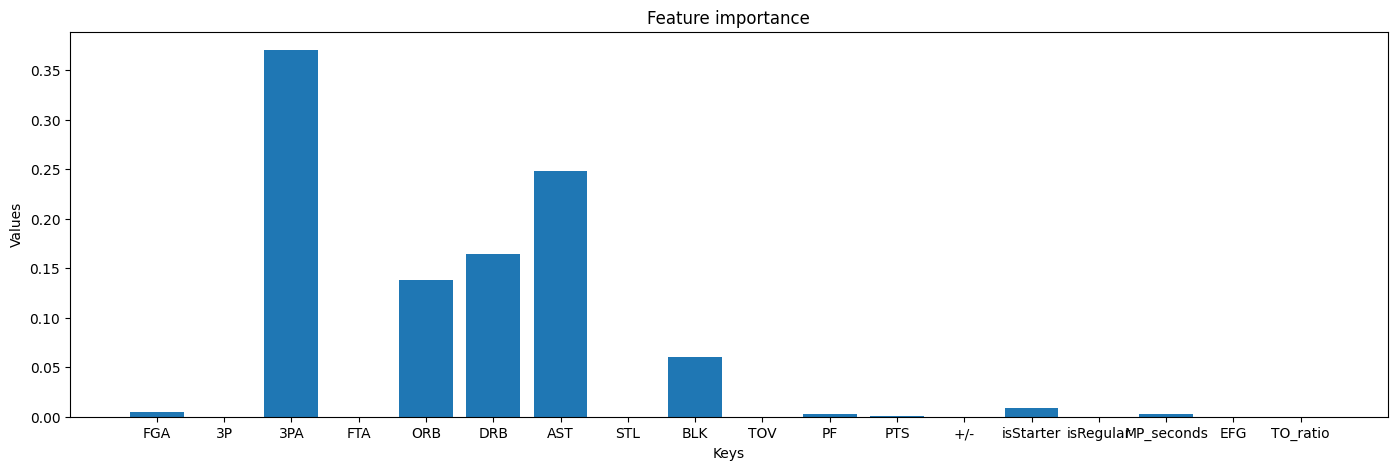

With parameters {'maxDepth': 7, 'maxBins': 16, 'impurity': 'gini'}
Validation accuracy = 0.49140260703688005


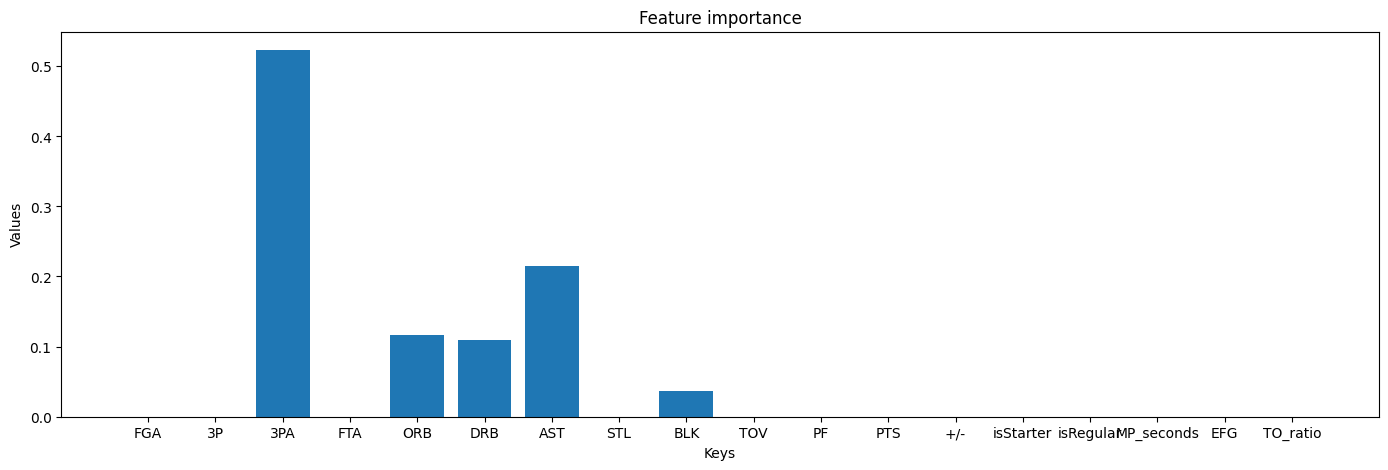

With parameters {'maxDepth': 3, 'maxBins': 16, 'impurity': 'gini'}
Validation accuracy = 0.4565493853327681


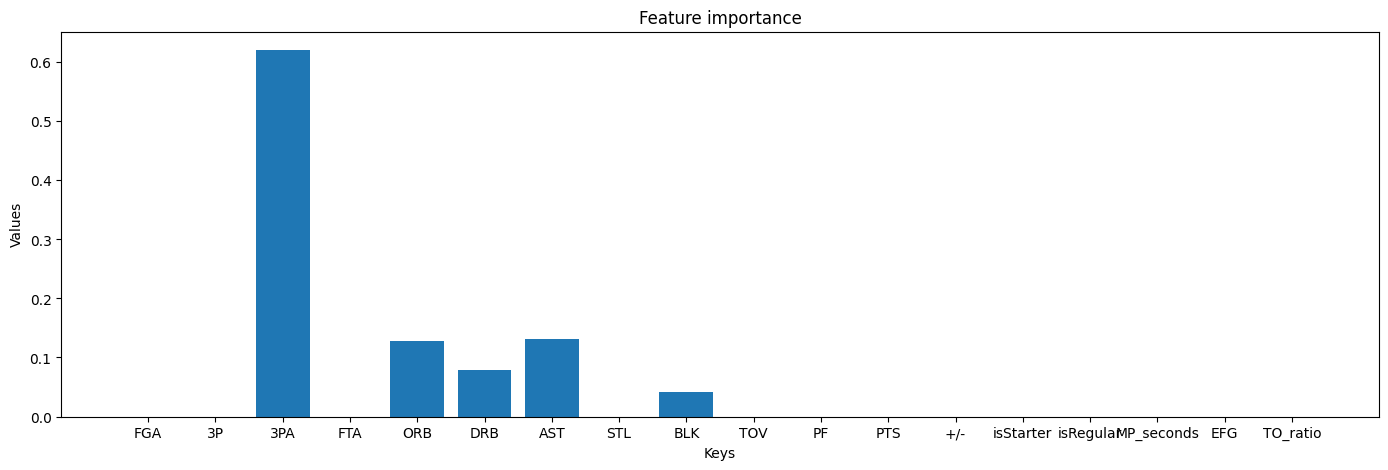

With parameters {'maxDepth': 3, 'maxBins': 32, 'impurity': 'entropy'}
Validation accuracy = 0.4565493853327681


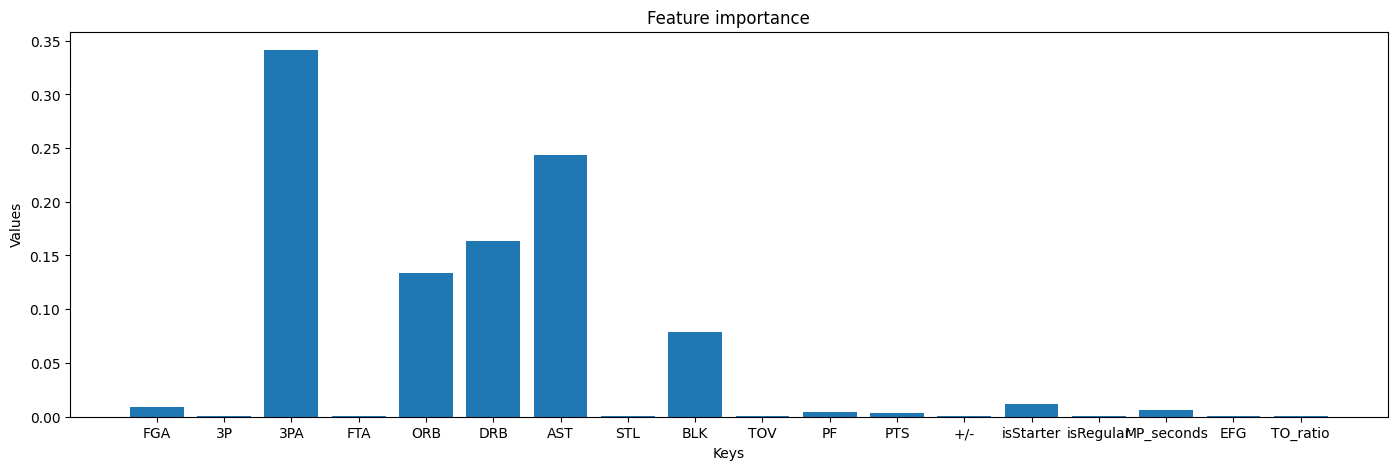

With parameters {'maxDepth': 9, 'maxBins': 32, 'impurity': 'gini'}
Validation accuracy = 0.49591988130563797


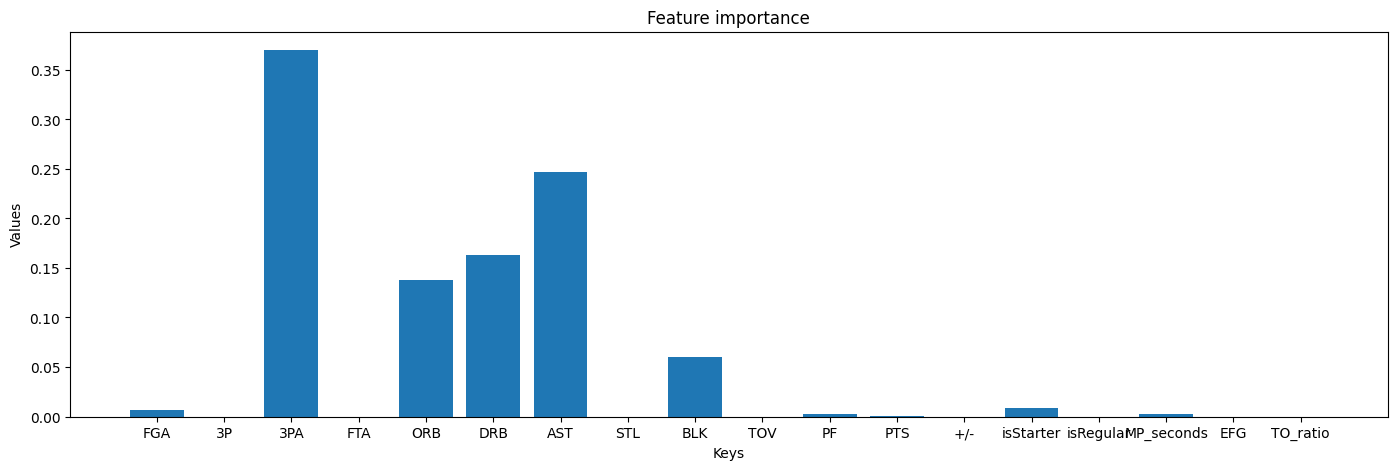

With parameters {'maxDepth': 7, 'maxBins': 64, 'impurity': 'gini'}
Validation accuracy = 0.4910979228486647


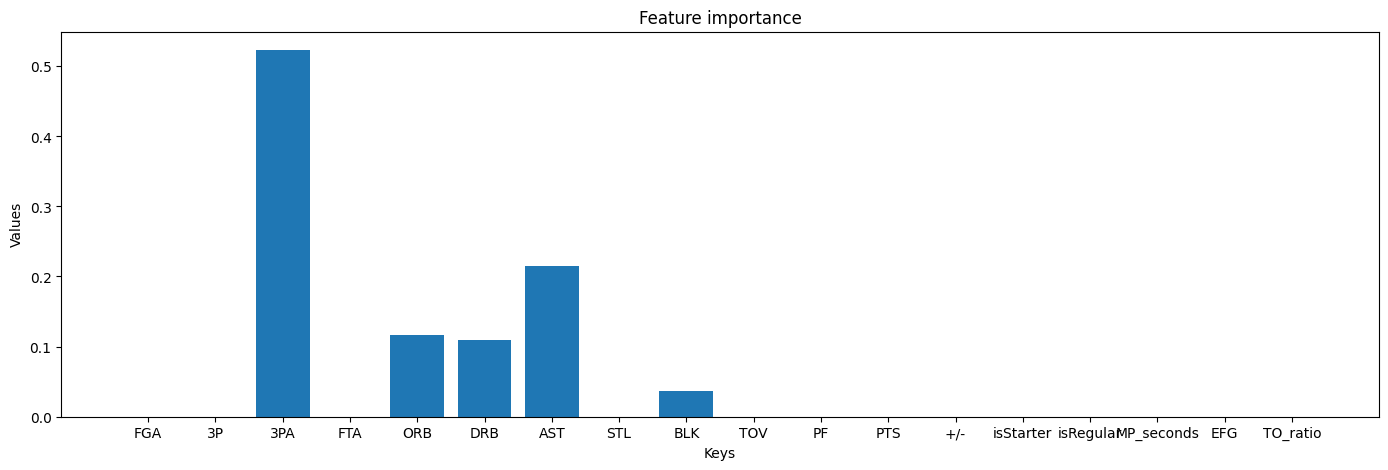

With parameters {'maxDepth': 3, 'maxBins': 32, 'impurity': 'gini'}
Validation accuracy = 0.4565493853327681


In [35]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
import random
import itertools

# random search
hyperparameters = {
    'maxDepth': [3, 5, 7, 9],
    'maxBins' : [16, 32, 64],
    'impurity' : ['gini', 'entropy']
}

number_of_combinations = 6
random_combinations = random.sample(list(itertools.product(*hyperparameters.values())), number_of_combinations)

for combo in random_combinations:
    param_dict = dict(zip(hyperparameters.keys(), combo))

    dt = DecisionTreeClassifier(labelCol="PosNum", featuresCol="features_scaled", impurity=param_dict['impurity'], maxDepth=param_dict['maxDepth'], maxBins=param_dict['maxBins'])

    dt = dt.fit(trainingData)

    importance = {}
    featureImportances = list(dt.featureImportances)

    for i,e in enumerate(featureImportances):
        importance[num_col[i]] = e
    
    plot_importance(importance)

    # Make predictions
    predictions = dt.transform(valData)

    # Select (prediction, true label) and compute test error
    evaluator = MulticlassClassificationEvaluator(labelCol="PosNum"
                                                , predictionCol="prediction"
                                                , metricName="accuracy")

    print('With parameters', param_dict)
    accuracy = evaluator.evaluate(predictions)
    print('Validation accuracy =', accuracy)

In [37]:
dt = DecisionTreeClassifier(labelCol="PosNum", featuresCol="features_scaled", impurity='entropy', maxDepth=9, maxBins=64)

dt = dt.fit(trainingData)

In [38]:
dt.featureImportances

SparseVector(18, {0: 0.0045, 2: 0.4318, 3: 0.0001, 4: 0.1408, 5: 0.14, 6: 0.1769, 7: 0.0006, 8: 0.0829, 9: 0.0002, 10: 0.005, 11: 0.0014, 12: 0.0002, 13: 0.0078, 15: 0.0065, 16: 0.0008, 17: 0.0005})

In [39]:
importance = {}
featureImportances = list(dt.featureImportances)

for i,e in enumerate(featureImportances):
    importance[num_col[i]] = e

importance

{'FGA': 0.004503976675378614,
 '3P': 0.0,
 '3PA': 0.4318060099347117,
 'FTA': 6.460359611639608e-05,
 'ORB': 0.14077916115722103,
 'DRB': 0.14004337454374105,
 'AST': 0.17688821135033847,
 'STL': 0.0005758171176473358,
 'BLK': 0.08292002903344908,
 'TOV': 0.0001761306612347348,
 'PF': 0.005035866418576497,
 'PTS': 0.0014029219335174629,
 '+/-': 0.00019031244211500958,
 'isStarter': 0.007824511884484985,
 'isRegular': 0.0,
 'MP_seconds': 0.006496059942534544,
 'EFG': 0.000784499621009097,
 'TO_ratio': 0.0005085136879240346}

In [40]:
# Make predictions
predictions = dt.transform(valData)

predictions.show(10)

+--------------------+------+--------------------+--------------------+----------+
|     features_scaled|PosNum|       rawPrediction|         probability|prediction|
+--------------------+------+--------------------+--------------------+----------+
|(18,[0,1,2,3,4,7,...|   0.0|[11802.0,5450.0,7...|[0.51740464708461...|       0.0|
|(18,[0,1,2,3,4,11...|   1.0|[11802.0,5450.0,7...|[0.51740464708461...|       0.0|
|(18,[0,1,2,3,4,11...|   0.0|[11802.0,5450.0,7...|[0.51740464708461...|       0.0|
|(18,[0,1,2,3,4,11...|   2.0|[11802.0,5450.0,7...|[0.51740464708461...|       0.0|
|(18,[0,1,2,3,4,11...|   3.0|[11802.0,5450.0,7...|[0.51740464708461...|       0.0|
|(18,[0,1,2,3,4,11...|   0.0|[11802.0,5450.0,7...|[0.51740464708461...|       0.0|
|(18,[0,1,2,3,4,11...|   0.0|[11802.0,5450.0,7...|[0.51740464708461...|       0.0|
|(18,[0,1,2,3,4,11...|   3.0|[11802.0,5450.0,7...|[0.51740464708461...|       0.0|
|(18,[0,1,2,3,5,6,...|   0.0|[11802.0,5450.0,7...|[0.51740464708461...|       0.0|
|(18

In [41]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="PosNum"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print('Validation accuracy =', accuracy)
print("Validation Error = %g" % (1.0 - accuracy))

predictions_test = dt.transform(testData)
accuracy_test = evaluator.evaluate(predictions_test)
print('Test accuracy =', accuracy_test)
print("Test Error = %g" % (1.0 - accuracy_test))

Validation accuracy = 0.4957211742263671
Validation Error = 0.504279
Test accuracy = 0.49725145765391837
Test Error = 0.502749


Using 'Ht', the decision tree obtains nearly 89% of accuracy. Without it, we reach 65% accuracy on the validation set.

## Multilayer Perceptron Classifier

In [43]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

layers = [18, 40, 20, 5]  # Define the layers of the neural network
mlp = MultilayerPerceptronClassifier(labelCol="PosNum", featuresCol="features_scaled", layers=layers, seed=12, maxIter=30)

model = mlp.fit(trainingData)

predictions = model.transform(valData)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="PosNum", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Validation accuracy:", accuracy)

Validation accuracy: 0.4882497880457821


In [44]:
predictions.show(20)

+--------------------+------+--------------------+--------------------+----------+
|     features_scaled|PosNum|       rawPrediction|         probability|prediction|
+--------------------+------+--------------------+--------------------+----------+
|(18,[0,1,2,3,4,7,...|   0.0|[-0.4066740163413...|[0.13996789563946...|       1.0|
|(18,[0,1,2,3,4,11...|   1.0|[-0.4267213075959...|[0.14516740588228...|       1.0|
|(18,[0,1,2,3,4,11...|   0.0|[-0.5751563612104...|[0.12360990903131...|       1.0|
|(18,[0,1,2,3,4,11...|   2.0|[-0.7997890676540...|[0.09570549806030...|       1.0|
|(18,[0,1,2,3,4,11...|   3.0|[-0.3568280006076...|[0.15586239761060...|       1.0|
|(18,[0,1,2,3,4,11...|   0.0|[0.70224876996347...|[0.37924509909821...|       0.0|
|(18,[0,1,2,3,4,11...|   0.0|[1.09170825424871...|[0.47466429025255...|       0.0|
|(18,[0,1,2,3,4,11...|   3.0|[0.45771222779042...|[0.31928890767366...|       1.0|
|(18,[0,1,2,3,5,6,...|   0.0|[1.03339469214884...|[0.43589540109246...|       0.0|
|(18

### Random search

In [45]:
import random
import itertools

# random search
hyperparameters = {
    'layer_size': [10, 20, 30, 40],
    'stepsize' : [0.005, 0.01, 0.03, 0.05],
    'layers': [2, 3, 4, 5],   # Define the layers of the neural network
    'epochs': [40, 60, 80],
}

number_of_combinations = 10
random_combinations = random.sample(list(itertools.product(*hyperparameters.values())), number_of_combinations)

num_classes = 5

for i, combo in enumerate(random_combinations):
    param_dict = dict(zip(hyperparameters.keys(), combo))

    layers = [18]
    for _ in range(param_dict['layers']):
        layers.append(param_dict['layer_size'])
    layers.append(num_classes)

    mlp = MultilayerPerceptronClassifier(labelCol="PosNum", featuresCol="features_scaled", layers=layers, stepSize=param_dict['stepsize'], maxIter=param_dict['epochs'])

    model = mlp.fit(trainingData)

    predictions = model.transform(valData)

    # Evaluate the model
    evaluator = MulticlassClassificationEvaluator(labelCol="PosNum", predictionCol="prediction", metricName="accuracy")
    print('With parameters', param_dict)
    accuracy = evaluator.evaluate(predictions)
    print("Validation accuracy for combo {}:".format(i), accuracy)

With parameters {'layer_size': 10, 'stepsize': 0.03, 'layers': 2, 'epochs': 40}
Validation accuracy for combo 0: 0.49344266638406103
With parameters {'layer_size': 30, 'stepsize': 0.05, 'layers': 3, 'epochs': 60}
Validation accuracy for combo 1: 0.49182651547265793
With parameters {'layer_size': 40, 'stepsize': 0.01, 'layers': 4, 'epochs': 40}
Validation accuracy for combo 2: 0.48423590504451036
With parameters {'layer_size': 20, 'stepsize': 0.05, 'layers': 3, 'epochs': 60}
Validation accuracy for combo 3: 0.49262134378974143
With parameters {'layer_size': 20, 'stepsize': 0.005, 'layers': 4, 'epochs': 60}
Validation accuracy for combo 4: 0.4850969690546842
With parameters {'layer_size': 10, 'stepsize': 0.03, 'layers': 4, 'epochs': 40}
Validation accuracy for combo 5: 0.46085470538363715
With parameters {'layer_size': 30, 'stepsize': 0.05, 'layers': 5, 'epochs': 80}
Validation accuracy for combo 6: 0.4909919457397202
With parameters {'layer_size': 40, 'stepsize': 0.005, 'layers': 5, 'ep